In [4]:
# Cell 2: Import Libraries and Load Dataset
from datasets import load_dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, get_cosine_with_hard_restarts_schedule_with_warmup
from transformers import AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SST5 dataset
ds = load_dataset("SetFit/sst5")
train_data = ds["train"]
val_data = ds["validation"]
test_data = ds["test"]

# Cell 3: Tokenization
xlnet_tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_data(data, tokenizer, max_length=128):
    return data.map(
        lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=max_length), 
        batched=True
    )

train_data_xlnet = tokenize_data(train_data, xlnet_tokenizer)
val_data_xlnet = tokenize_data(val_data, xlnet_tokenizer)

def convert_to_torch(data, batch_size=32):
    data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=True)

train_loader_xlnet = convert_to_torch(train_data_xlnet)
val_loader_xlnet = convert_to_torch(val_data_xlnet)

# Cell 4: Custom Model with Dropout Regularization
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoModel

class XLNetWithDropout(nn.Module):
    def __init__(self, model_name, num_labels):
        super(XLNetWithDropout, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)  # Use AutoModel instead of AutoModelForSequenceClassification
        self.dropout = nn.Dropout(0.4)
        
        # Match hidden size (e.g., 768 for xlnet-base-cased)
        hidden_size = self.model.config.hidden_size  
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Extract the last hidden state (sequence output)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)
        
        # Pool the output (use mean pooling, CLS token, or another strategy)
        pooled_output = torch.mean(hidden_states, dim=1)  # Shape: (batch_size, hidden_size)

        # Apply dropout and classifier
        logits = self.classifier(self.dropout(pooled_output))  # Shape: (batch_size, num_labels)
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


# Cell 5: Training and Evaluation Functions
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    return get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=num_warmup_steps, 
        num_training_steps=num_training_steps
    )

def compute_regularization_loss(model, l1_lambda, l2_lambda):
    l1_reg = 0.0
    l2_reg = 0.0
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    for name, param in model.named_parameters():
        if 'bias' not in name and 'LayerNorm' not in name and 'layer_norm' not in name:
            l1_reg += torch.sum(torch.abs(param))
            l2_reg += torch.sum(param.pow(2)) / 2
    
    return (l1_lambda * l1_reg + l2_lambda * l2_reg) / num_params

def evaluate_model(model, data_loader, device="cuda", show_cm=True):
    model.eval()
    true_labels, pred_labels = [], []
    
    with torch.no_grad():
        for batch in data_loader:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            labels = batch["label"].to(device)
            
            outputs = model(**inputs)
            preds = torch.argmax(outputs["logits"], dim=-1)
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average="weighted")
    
    if show_cm:
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    
    return accuracy, f1

# Cell 6: Training Final Model
def train_final_model(model, train_loader, val_loader, device, num_epochs=50, 
                      learning_rate=1e-6, l1_lambda=1e-5, l2_lambda=1e-6):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_scheduler(
        optimizer, 
        num_warmup_steps=100, 
        num_training_steps=len(train_loader) * num_epochs
    )
    
    model.to(device)
    training_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'labels': batch['label'].to(device)
            }
            
            outputs = model(**inputs)
            loss = outputs["loss"] + compute_regularization_loss(model, l1_lambda, l2_lambda)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_losses.append(loss.item())
        
        # Calculate train loss
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        training_losses.append(avg_epoch_loss)
        
        # Validate
        model.eval()
        total_val_loss, true_labels, pred_labels = 0, [], []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {
                    'input_ids': batch['input_ids'].to(device),
                    'attention_mask': batch['attention_mask'].to(device),
                    'labels': batch['label'].to(device)
                }
                
                outputs = model(**inputs)
                loss = outputs["loss"]
                total_val_loss += loss.item()
                
                preds = torch.argmax(outputs["logits"], dim=-1)
                true_labels.extend(inputs['labels'].cpu().numpy())
                pred_labels.extend(preds.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_accuracy, val_f1 = evaluate_model(model, val_loader, device, show_cm=False)
        
        print(f"Epoch {epoch + 1}: Loss = {avg_epoch_loss:.4f}, "
              f"Val_loss = {avg_val_loss:.4f}, "
              f"Val F1 = {val_f1:.4f}, "
              f"Val_accuracy = {val_accuracy:.4f}")
    
    return training_losses, val_losses



Repo card metadata block was not found. Setting CardData to empty.


Epoch 1: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 1: Loss = 2.0216, Val_loss = 1.7597, Val F1 = 0.1464, Val_accuracy = 0.2743


Epoch 2: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 2: Loss = 1.6157, Val_loss = 1.6478, Val F1 = 0.1627, Val_accuracy = 0.2843


Epoch 3: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 3: Loss = 1.5285, Val_loss = 1.4685, Val F1 = 0.2755, Val_accuracy = 0.3733


Epoch 4: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 4: Loss = 1.3638, Val_loss = 1.2485, Val F1 = 0.4023, Val_accuracy = 0.4668


Epoch 5: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 5: Loss = 1.2617, Val_loss = 1.2322, Val F1 = 0.4295, Val_accuracy = 0.4750


Epoch 6: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 6: Loss = 1.2164, Val_loss = 1.2050, Val F1 = 0.4487, Val_accuracy = 0.4959


Epoch 7: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 7: Loss = 1.1632, Val_loss = 1.1692, Val F1 = 0.4617, Val_accuracy = 0.5068


Epoch 8: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 8: Loss = 1.1440, Val_loss = 1.1467, Val F1 = 0.4656, Val_accuracy = 0.5050


Epoch 9: 100%|██████████| 267/267 [02:12<00:00,  2.02it/s]


Epoch 9: Loss = 1.1181, Val_loss = 1.1635, Val F1 = 0.4679, Val_accuracy = 0.5077


Epoch 10: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 10: Loss = 1.1042, Val_loss = 1.1369, Val F1 = 0.4940, Val_accuracy = 0.5223


Epoch 11: 100%|██████████| 267/267 [02:12<00:00,  2.02it/s]


Epoch 11: Loss = 1.0962, Val_loss = 1.1367, Val F1 = 0.4842, Val_accuracy = 0.5150


Epoch 12: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 12: Loss = 1.0865, Val_loss = 1.1246, Val F1 = 0.4955, Val_accuracy = 0.5213


Epoch 13: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 13: Loss = 1.0730, Val_loss = 1.1336, Val F1 = 0.4906, Val_accuracy = 0.5195


Epoch 14: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 14: Loss = 1.0560, Val_loss = 1.1449, Val F1 = 0.4938, Val_accuracy = 0.5213


Epoch 15: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 15: Loss = 1.0644, Val_loss = 1.1325, Val F1 = 0.4971, Val_accuracy = 0.5250


Epoch 16: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 16: Loss = 1.0621, Val_loss = 1.1277, Val F1 = 0.4985, Val_accuracy = 0.5259


Epoch 17: 100%|██████████| 267/267 [02:12<00:00,  2.02it/s]


Epoch 17: Loss = 1.0544, Val_loss = 1.1362, Val F1 = 0.4942, Val_accuracy = 0.5223


Epoch 18: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 18: Loss = 1.0445, Val_loss = 1.1455, Val F1 = 0.4934, Val_accuracy = 0.5204


Epoch 19: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 19: Loss = 1.0457, Val_loss = 1.1391, Val F1 = 0.4908, Val_accuracy = 0.5177


Epoch 20: 100%|██████████| 267/267 [02:11<00:00,  2.02it/s]


Epoch 20: Loss = 1.0471, Val_loss = 1.1337, Val F1 = 0.4908, Val_accuracy = 0.5177


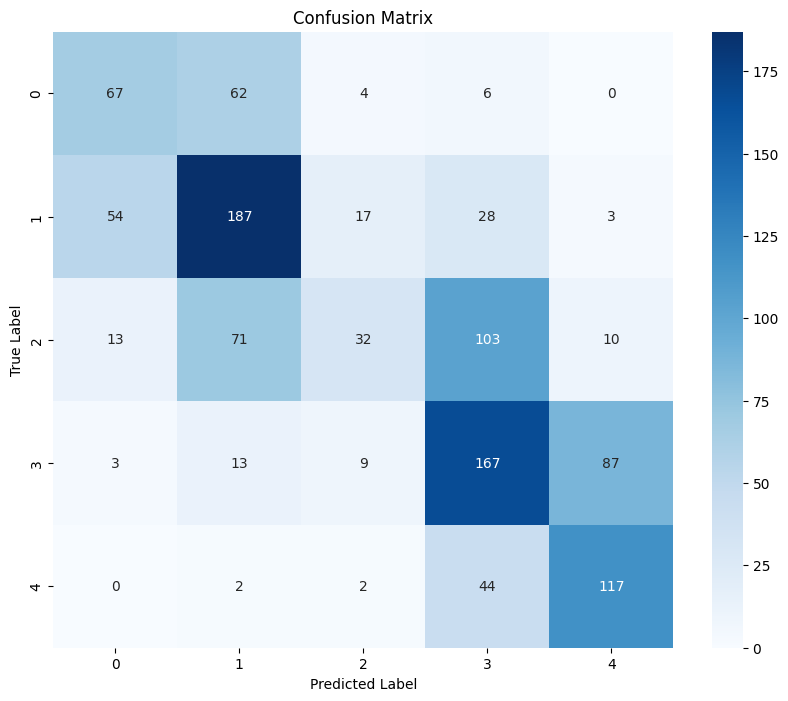

Final Validation Accuracy: 0.5177
Final Validation F1 Score: 0.4908


In [5]:
# Cell 7: Run Training
# Initialize model
final_model = XLNetWithDropout("xlnet-base-cased", num_labels=5)
# Train the model for 50 epochs
training_losses, val_losses = train_final_model(
    final_model, 
    train_loader_xlnet, 
    val_loader_xlnet, 
    device,
    num_epochs=20
)

# Evaluate final model
final_accuracy, final_f1 = evaluate_model(final_model, val_loader_xlnet, device)
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"Final Validation F1 Score: {final_f1:.4f}")




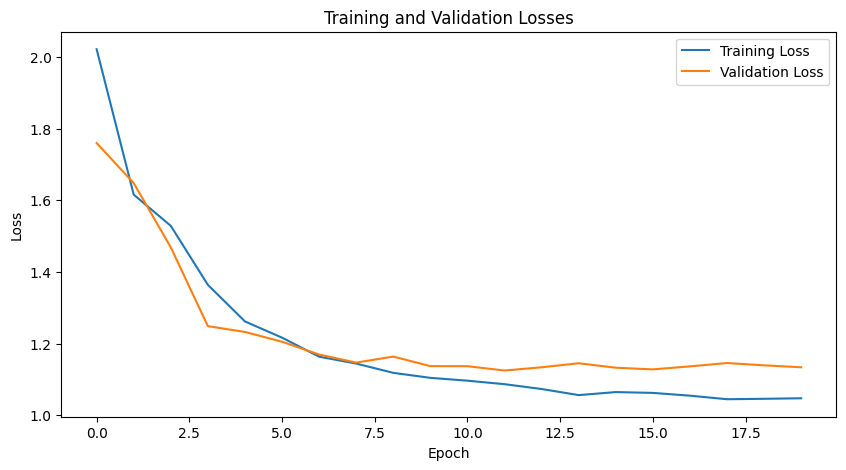

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()